# Implicit orthogonal regression

Estimate the parameters of an ellipse from a set of coordinates.

$$\begin{align*}
f(\bm{X}, \bm{\beta}) & = \frac{\left[(x-x_0)\cos\theta + (y-y_0)\sin\theta\right]^2}{a^2} \\
& + \frac{\left[(y-y_0)\cos\theta -(x-x_0)\sin\theta\right]^2}{b^2} - 1 = 0
\end{align*}$$

$$ \bm{X} = (x,y) $$

$$ \bm{\beta} = (x_0, y_0, a, b, \theta) $$

In [1]:
import Pkg
Pkg.activate("..")
using Odrpack

using Plots

  Activating project at `/home/Odrpack`


First, we define the observed data and the model function. 

In [2]:
# Each row represents a point (x, y) of the ellipse
Xdata = [
    0.50 -0.12
    1.20 -0.60
    1.60 -1.00
    1.86 -1.40
    2.12 -2.54
    2.36 -3.36
    2.44 -4.00
    2.36 -4.75
    2.06 -5.25
    1.74 -5.64
    1.34 -5.97
    0.90 -6.32
    -0.28 -6.44
    -0.78 -6.44
    -1.36 -6.41
    -1.90 -6.25
    -2.50 -5.88
    -2.88 -5.50
    -3.18 -5.24
    -3.44 -4.86
]

# Ydata is not used, but is required
Ydata = zeros(size(Xdata, 1), 1);

In [3]:
function f!(X, beta, Y)
    x0, y0, a, b, θ = beta
    x = X[:, 1]
    y = X[:, 2]
    Y .=  ((x .- x0) * cos(θ) .+ (y .- y0) * sin(θ)).^2 / a^2 .+ 
          ((y .- y0) * cos(θ) .- (x .- x0) * sin(θ)).^2 / b^2 .- 1
    return nothing
end

f! (generic function with 1 method)

Then, we define a plausible initial guess $\bm{\beta_0}$ for the model parameters, as well as the corresponding bounds.

In [4]:
beta0 =[0.0, 0.0, 1.0, 1.0, 0.0]

lower = [-1e2, -1e2, 0e0, 0e0, -π/2]
upper = [+1e2, +1e2, 1e2, 1e2, +π/2];

Here, we expect the measurement error to be the same across both $\bm{X}$ coordinates, so a special weighting scheme is unnecessary.

In [5]:
weight_x = 1.0;

We can now launch the regression! As the problem is implicit, we set `task="implicit-ODR"`. If you want to see a brief computation report, set `report="short"`.

In [6]:
sol = odr_fit(f!, Xdata, Ydata, beta0,
    bounds=(lower, upper), weight_x=weight_x,
    task="implicit-ODR", report="none");

The result is packed in a `OdrResult` struct. Let's check the solution convergence and the estimated model parameters.

In [7]:
sol.stopreason

"Parameter convergence."

In [8]:
sol.beta

5-element Vector{Float64}:
 -0.9993794166503656
 -2.931050032879667
  3.8642229796501475
  3.1566376046094664
 -0.9035913565876814

All fine! Let's plot the solution.

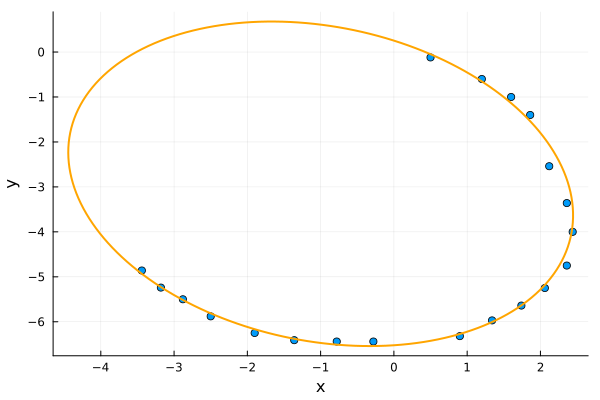

In [9]:
# Plot observed data
scatter(Xdata[:, 1], Xdata[:, 2], label="Data", legend=false)

# Plot fitted ellipse
x0, y0, a, b, θ = sol.beta

t = range(0, 2π; length=200)
ellipse_x = x0 .+ a .* cos.(t) .* cos(θ) .- b .* sin.(t) .* sin(θ)
ellipse_y = y0 .+ a .* cos.(t) .* sin(θ) .+ b .* sin.(t) .* cos(θ)
plot!(ellipse_x, ellipse_y, color=:orange, linewidth=2, label="Fit")

xlabel!("x")
ylabel!("y")